In [49]:
# If the import fails, run this
#!pip install -q tensorflow-datasets
import tensorflow as tf
import tensorflow_datasets as tfds
imdb, info = tfds.load("imdb_reviews/subwords8k", with_info=True, as_supervised=True, batch_size=128, download=False)


In [51]:
train_data, test_data = imdb['train'], imdb['test']

In [40]:
print(test_data)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [52]:
tokenizer = info.features['text'].encoder

у нас есть предварительно обученный токенайзер подслов, поэтому мы можем проверить его словарь, посмотрев на его свойство `subwords`. 

In [53]:
print(tokenizer.subwords)

['the_', ', ', '. ', 'a_', 'and_', 'of_', 'to_', 's_', 'is_', 'br', 'in_', 'I_', 'that_', 'this_', 'it_', ' /><', ' />', 'was_', 'The_', 'as_', 't_', 'with_', 'for_', '.<', 'on_', 'but_', 'movie_', ' (', 'are_', 'his_', 'have_', 'film_', 'not_', 'ing_', 'be_', 'ed_', 'you_', ' "', 'it', 'd_', 'an_', 'he_', 'by_', 'at_', 'one_', 'who_', 'y_', 'from_', 'e_', 'or_', 'all_', 'like_', 'they_', '" ', 'so_', 'just_', 'has_', ') ', 'her_', 'about_', 'out_', 'This_', 'some_', 'ly_', 'movie', 'film', 'very_', 'more_', 'It_', 'would_', 'what_', 'when_', 'which_', 'good_', 'if_', 'up_', 'only_', 'even_', 'their_', 'had_', 'really_', 'my_', 'can_', 'no_', 'were_', 'see_', 'she_', '? ', 'than_', '! ', 'there_', 'get_', 'been_', 'into_', ' - ', 'will_', 'much_', 'story_', 'because_', 'ing', 'time_', 'n_', 'we_', 'ed', 'me_', ': ', 'most_', 'other_', 'don', 'do_', 'm_', 'es_', 'how_', 'also_', 'make_', 'its_', 'could_', 'first_', 'any_', "' ", 'people_', 'great_', 've_', 'ly', 'er_', 'made_', 'r_', 'B

Посмотрите, словарь довольно короткий. Это связано с тем, что вариантов разных фрагментов слов гораздо меньше, чем самих слов. А букв - вообще всего несколько десятков. 

***Разбиение слов на подслова - хороший способ сделать компактный универсальный словарь, и так же попытка некоторого разбора слов по составу, что необходимо в случае с таким языком как русский, с его приставками суффиксами и окончаниями.***

In [43]:
print(len(tokenizer.subwords))

7928


Если мы хотим увидеть, как он кодирует или декодирует строки, мы можем сделать это с помощью этого кода:

In [54]:
sample_string = 'TensorFlow, from basics to mastery'

tokenized_string = tokenizer.encode(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer.decode(tokenized_string)
print ('The original string: {}'.format(original_string))


Tokenized string is [6307, 2327, 4043, 2120, 2, 48, 4249, 4429, 7, 2652, 8050]
The original string: TensorFlow, from basics to mastery


In [55]:
for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer.decode([ts])))

6307 ----> Ten
2327 ----> sor
4043 ----> Fl
2120 ----> ow
2 ----> , 
48 ----> from 
4249 ----> basi
4429 ----> cs 
7 ----> to 
2652 ----> master
8050 ----> y


Теперь давайте посмотрим на классификацию IMDB с фрагментами слов. 
Эта  модель выглядит очень знакомо, однако тут следует учитывать форму векторов, проходящих от токенайзера через слой embedding, и их не получится "расплющить", как мы это делали раньше. Так что вместо этого мы будем использовать GlobalAveragePooling1D. Попытка использовать функцию `Flatten` приведет к падению TensorFlow.

In [56]:
embedding_dim = 64
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer.vocab_size, embedding_dim),
    # tf.keras.layers.Flatten(),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, None, 64)          523840    
                                                                 
 global_average_pooling1d_5   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_24 (Dense)            (None, 6)                 390       
                                                                 
 dense_25 (Dense)            (None, 1)                 7         
                                                                 
Total params: 524,237
Trainable params: 524,237
Non-trainable params: 0
_________________________________________________________________


Обучение здесь работает с большим количеством гиперпараметров и подслов, поэтому имейте в виду, оно будет медленным. Запуск на Colab с GPU занял у меня около четырех с половиной минут на эпоху.

In [57]:
num_epochs = 10

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

history = model.fit(train_data, epochs=num_epochs, validation_data=test_data)

Epoch 1/10
196/196 [==============================] - 47s 233ms/step - loss: 0.6907 - accuracy: 0.5383 - val_loss: 0.6856 - val_accuracy: 0.5061
Epoch 2/10
196/196 [==============================] - 2s 10ms/step - loss: 0.6610 - accuracy: 0.6693 - val_loss: 0.6229 - val_accuracy: 0.7228
Epoch 3/10
196/196 [==============================] - 2s 9ms/step - loss: 0.5391 - accuracy: 0.7918 - val_loss: 0.4800 - val_accuracy: 0.8075
Epoch 4/10
196/196 [==============================] - 2s 9ms/step - loss: 0.4055 - accuracy: 0.8546 - val_loss: 0.3903 - val_accuracy: 0.8544
Epoch 5/10
196/196 [==============================] - 2s 9ms/step - loss: 0.3320 - accuracy: 0.8799 - val_loss: 0.3495 - val_accuracy: 0.8670
Epoch 6/10
196/196 [==============================] - 2s 9ms/step - loss: 0.2897 - accuracy: 0.8944 - val_loss: 0.3287 - val_accuracy: 0.8722
Epoch 7/10
196/196 [==============================] - 3s 15ms/step - loss: 0.2615 - accuracy: 0.9055 - val_loss: 0.3171 - val_accuracy: 0.8762
E

Если ваши результаты не выглядят хорошими, не беспокойтесь, так и должно было случиться.

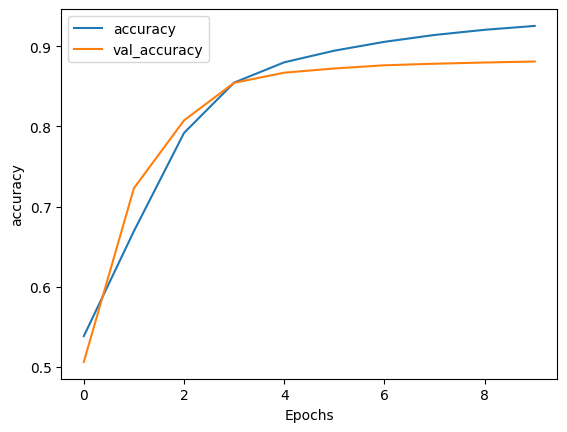

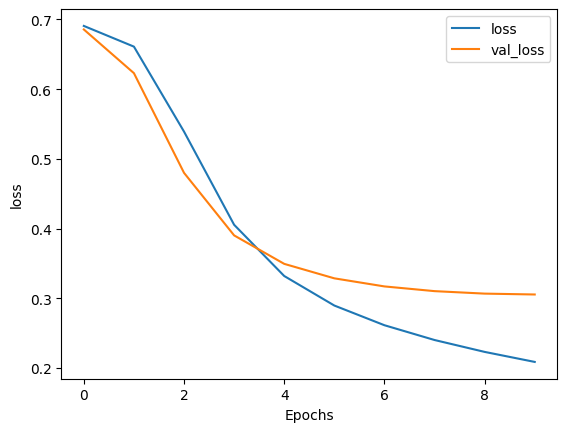

In [59]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

Почему же, по-вашему мнению, всё так плохо? 
Попробуйте ответить самостоятельно.

# Спойлер

Дело в том, что мы используем подслова, а многие подслова часто не имеют смысла сами по себе, и только если стоят в какой-то последовательности, имеют значимую семантику. Таким образом, обучение на последовательностях подслов будет отличным шагом вперед, и это именно то, что вы узнаете в следующей лекции "**Нейронные сети последовательностей**"